# Advanced Data Science Capstone - Week 3 - Model Definition - LSTM Network 

In this notebook we will define a Deep Learning model that will be used altogether for the sentiment analysis task. Here, we will define the network called LSTM, a class inside Recurrent Neural Networks.

Deep Learning models are well suited for sentiment classification and unstructured data analysis since they are able to capture order information on texts segmentation. Usually, for traditional classifier we loose order information when processing the Bag of Words, here we will not take it away. Also, we used our dataset processed with word embeddings, and a variety of architectures and text processing combinations will be used to check which one has highest perform.

We will use the library named pytorch to implement the Deep Learning models. Pytorch is in a lower level than Keras, but they are also ease to use and intuitive. All arquitetures is in a file named models.py, and function to help process data is in utils.py

In [1]:
# importing data
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

data = pd.read_csv("data/data_preprocessed.csv", sep='\t')

# checking its dimensions
data.shape

(14133, 24)

In [2]:
import utils

data['text_preprocessed'] = data.text.apply(lambda x: utils.preprocess_tweet(x, punctuation = True))
data['text_preprocessed'] = data.text_preprocessed.apply(lambda x: utils.preprocess_text(x))
data['text_preprocessed'].values[0:3]

array([list(['what', 'said', '<PERIOD>']),
       list(['plus', "you've", 'added', 'commercials', 'to', 'the', 'experience', 'tacky', '<PERIOD>']),
       list(['i', "didn't", 'today', 'must', 'mean', 'i', 'need', 'to', 'take', 'another', 'trip', '<EXCLAMATION_MARK>'])], dtype=object)

In [3]:
from sklearn.model_selection import train_test_split

# our feature and label data
text, y = data['text_preprocessed'], data['airline_sentiment']

# train-test split
text_train, text_test, y_train, y_test = train_test_split(text, y, test_size=0.10, random_state=37)
text_train.shape, text_test.shape

((12719,), (1414,))

### Baseline

In [4]:
pd.concat([pd.Series(y_train, name = 'Train distribution data').value_counts(normalize=True),
           pd.Series(y_test, name = 'Test distribution data').value_counts(normalize=True)], axis = 1)

,Train distribution data,Test distribution data
negative,0.638494,0.652758
neutral,0.207878,0.188826
positive,0.153628,0.158416


In [5]:
# create a list of all words in the data set
words = [word for text in text_train.values for word in text]

print("Len {}".format(len(words)))
print("Unique words {}".format(len(set(words))))

Len 241297
Unique words 11808


In [6]:
# feel free to use this import 
from collections import Counter

## Build a dictionary that maps words to integers
vocab_to_int = {word:(ii+1) for ii, word in enumerate(set(words))}

## use the dict to tokenize each review in reviews_split
## store the tokenized reviews in reviews_ints
def tokenize_custom(review):
    new_review = []
    for word in review:
        try:
            new_review.append(vocab_to_int[word])
        except Exception as e:
            pass
    return new_review

tweets = text_train.values
reviews_ints = [tokenize_custom(word) for word in tweets]
reviews_ints[0:2]

[[10803,
  9043,
  6841,
  4947,
  4470,
  7522,
  10343,
  4186,
  4415,
  944,
  6320,
  6996,
  660,
  6320,
  11354,
  6415,
  4291,
  3731,
  6841,
  9609,
  11393,
  9113,
  9016],
 [5401, 269, 4886, 5890, 4614, 6074, 11273, 8579, 1597]]

Before continuing, we need to do the same thing for test set. I will do everything in just one cell.

In [7]:
tweets_test = text_test.values

# we dont do vocab_to_int again, because if a word is not mapped, we just replace it with zeros
reviews_ints_test = [tokenize_custom(word) for word in tweets_test]
reviews_ints_test[0:2]

[[5670,
  9290,
  2001,
  5670,
  2717,
  2001,
  9560,
  5670,
  6691,
  2716,
  4869,
  3482,
  4186,
  10323,
  11599,
  6320,
  9170,
  4262,
  7165,
  2001,
  3710,
  1673,
  8810,
  6320,
  4050,
  1597,
  3050,
  7288,
  6974],
 [8096,
  3871,
  6727,
  6841,
  2414,
  9057,
  8917,
  7044,
  2828,
  6320,
  4308,
  1600,
  11224,
  11370,
  273,
  8025,
  7288,
  3559,
  6320]]

In [8]:
# stats about vocabulary
print('Unique words: ', len((vocab_to_int)))  # should ~ 74000+
print()

# print tokens in first review
print('Tokenized review: \n', reviews_ints[:1])

Unique words:  11808

Tokenized review: 
 [[10803, 9043, 6841, 4947, 4470, 7522, 10343, 4186, 4415, 944, 6320, 6996, 660, 6320, 11354, 6415, 4291, 3731, 6841, 9609, 11393, 9113, 9016]]


In [9]:
# outlier review stats
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 0
Maximum review length: 42


In [10]:
# Test your implementation!
seq_length = 30

# pad_features will put zeros in front of a tweet in order that all have the same length.
features_train = utils.pad_features(reviews_ints, seq_length=seq_length)
features_test = utils.pad_features(reviews_ints_test, seq_length=seq_length)

## test statements - do not change - ##
assert len(features_train)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features_train[0])==seq_length, "Each feature row should contain seq_length values."

# print first 10 values of the first 30 batches 
print(features_train[3,:30])

[     0.      0.      0.      0.      0.   2001.   8453.   8975.   3945.
    286.   5890.   5024.   6320.   4219.   8975.    384.    413.    454.
   2001.   8810.   6320.  10328.  10968.   9560.   5498.   1597.  10591.
   4482.  11370.   1597.]


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder().fit(y_train.values.ravel())

y_train = le.transform(y_train.values.ravel())
y_test = le.transform(y_test.values.ravel())

labels_train = np.asarray(y_train)
labels_test = np.asarray(y_test)

In [12]:
split_frac = 0.9
#
### split data into training, validation
#
n_samples = features_train.shape[0]
idx_train = np.int(n_samples*split_frac)

train_x, train_y = features_train[:idx_train-7, :], labels_train[:idx_train-7]
validation_x, validation_y = features_train[idx_train+2:, :], labels_train[idx_train+2:]
test_x, test_y = features_test[:-4,:], labels_test[:-4]

## print out the shapes of your resultant feature data
train_x.shape, validation_x.shape, test_x.shape

((11440, 30), (1270, 30), (1410, 30))

In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(validation_x), torch.from_numpy(validation_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 10

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [18]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([10, 30])
Sample input: 
 tensor([[    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
          2716.,   789.,  1597.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,  7409.,  4787.,  3649.,  6461.,   290.,
          7522.,  6443.,  4886.,  6841., 11745.,  9689.,  2496.,  9663.,  2300.,
          1597.,  1597.,  1597.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,  2872.,  4905.,
          9057.,  5043., 11252.,  8025.,  4262.,  5653.,  6422.,  5039.,  2729.,
          4308.,  1254.,  4051.,  8727.,  9663.,  9412.,   504.,  9663., 10516.,
          6788.,  1597.,  5627.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  5913.,  7288.

In [19]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [20]:
from models import SentimentRNN

# Instantiate the model w/ hyperparams
vocab_size = len((vocab_to_int))+1
output_size = 3
embedding_dim = 200
hidden_dim = 256
n_layers = 3

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(11809, 200)
  (lstm): LSTM(200, 256, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


In [21]:
import torch.nn as nn

# loss and optimization functions
lr = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum = 0.9)

In [22]:
net.train_data(train_loader, valid_loader, batch_size, 
          criterion, optimizer, saving_path = 'models/model_pure_200dims.pt',
               lr = lr, clip = 5, num_epochs = 20)

Epoch: 1/20... Training Loss: 0.830563... Valid Loss: 0.742851... Valid Accuracy: 0.685
Saving../
Epoch: 2/20... Training Loss: 0.686241... Valid Loss: 0.682811... Valid Accuracy: 0.733
Saving../
Epoch: 3/20... Training Loss: 0.606735... Valid Loss: 0.610848... Valid Accuracy: 0.758
Saving../
Epoch: 4/20... Training Loss: 0.540049... Valid Loss: 0.602361... Valid Accuracy: 0.753
Saving../
Epoch: 5/20... Training Loss: 0.484777... Valid Loss: 0.576417... Valid Accuracy: 0.777
Saving../
Epoch: 6/20... Training Loss: 0.427329... Valid Loss: 0.616530... Valid Accuracy: 0.776
Epoch: 7/20... Training Loss: 0.383976... Valid Loss: 0.596268... Valid Accuracy: 0.774
Epoch: 8/20... Training Loss: 0.322043... Valid Loss: 0.675414... Valid Accuracy: 0.773
Epoch: 9/20... Training Loss: 0.277741... Valid Loss: 0.651331... Valid Accuracy: 0.768
Epoch: 10/20... Training Loss: 0.227370... Valid Loss: 0.748298... Valid Accuracy: 0.773
Epoch: 11/20... Training Loss: 0.178126... Valid Loss: 0.897933... Va

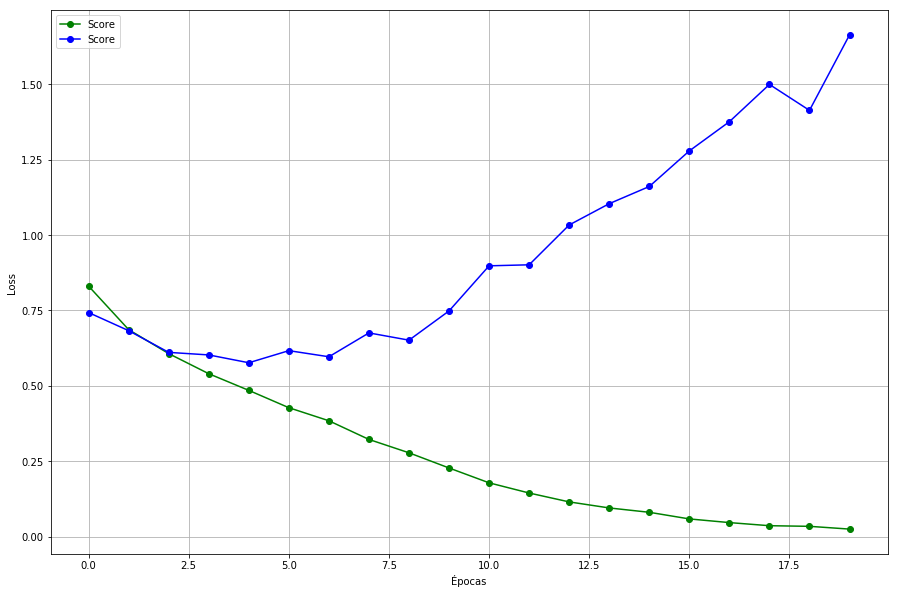

In [23]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots()

ax.plot(list(range(len(net.train_history))), net.train_history, 'g-o', label = 'Score')
ax.plot(list(range(len(net.valid_history))), net.valid_history, 'b-o', label = 'Score', )
ax.legend()
ax.set_xlabel('Épocas')
ax.set_ylabel('Loss')
ax.grid()

fig.set_figheight(10)
fig.set_figwidth(15)

In [26]:
# Loading the best model

print(net.test(test_loader, batch_size, criterion))

checkpoint = torch.load('model_pure_200dims.pt')
net.load_state_dict(checkpoint['model_state_dict'])

net.test(test_loader, batch_size, criterion)

Test loss: 0.570 Test accuracy: 0.773
None
Test loss: 0.571 Test accuracy: 0.775


In [27]:
# saving predictions
def saving_preds(name, model, flag):
    parameter = model.predictions if flag=='preds' else model.labels
    y_pred = [prediction for list_ in parameter 
                   for prediction in list_.cpu().numpy()]
    y_pred = np.array(y_pred)
    np.save(name, y_pred)
    
saving_preds('data/y_pred_net_200', net, flag = 'preds')
saving_preds('data/y_test_net_200', net, flag = 'labels')

### LSTM + Glove Embeddings

In [28]:
import csv

PATH = 'word_embeddings/glove.twitter.27B.200d.txt'
glovewords = pd.read_table(PATH, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

In [29]:
glovewords.loc['the', :]

1      0.493500
2      0.356980
3      0.660680
4     -0.032975
5      0.249890
6      0.259360
7     -0.027169
8      0.068403
9     -0.290630
10    -0.457050
11    -0.077940
12     0.325160
13    -1.485200
14    -0.067472
15    -0.170330
16    -0.009296
17     0.346280
18    -0.011575
19     0.037965
20     0.456170
21     0.080486
22     0.153100
23    -0.153090
24    -0.188100
25    -0.181950
26     0.872450
27     0.397920
28     0.409950
29     0.449820
30    -0.001965
         ...   
171   -0.182710
172    0.296100
173    0.218550
174    0.192330
175    0.152290
176   -0.013649
177   -0.050622
178   -0.096446
179    0.015646
180    0.511670
181    0.147230
182   -0.081492
183   -0.310690
184   -0.111670
185   -0.134330
186    0.366700
187   -0.296590
188   -0.499520
189   -0.060474
190    0.004695
191   -0.166170
192   -0.170180
193    0.112330
194    0.160400
195   -0.171420
196   -0.156210
197   -0.113660
198    0.177060
199   -0.536950
200   -0.296990
Name: the, Length: 200, 

Now, we need to map our indices to words and its respective wordVec in glove model.

In [30]:
int_to_vocab = {value:item for item, value in vocab_to_int.items()}

embedded_dim = 200
matrix_len = len((vocab_to_int))+1
weights_matrix = np.zeros((matrix_len, embedded_dim))
words_found = 0
words_not_found = []

for word in vocab_to_int:
    try:
        i = vocab_to_int[word]
        weights_matrix[i] = glovewords.loc[word, :]
        words_found += 1
    except KeyError:
        words_not_found.append(word)
        weights_matrix[i] = np.random.normal(scale=0.6, size=(embedded_dim, ))

In [31]:
print('Words found {}'.format(words_found))
weights_matrix.shape

Words found 8820


(11809, 200)

In [32]:
model_glove = SentimentRNN(vocab_size, output_size, embedded_dim, hidden_dim, n_layers)

lr = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_glove.parameters(), lr=lr, momentum = 0.9)

print(model_glove)

SentimentRNN(
  (embedding): Embedding(11809, 200)
  (lstm): LSTM(200, 256, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


In [33]:
weights = torch.from_numpy(weights_matrix)
model_glove.embedding.load_state_dict({'weight': weights})

model_glove.embedding.weight.requires_grad = False

In [34]:
model_glove.train_data(train_loader, valid_loader, batch_size, 
          criterion, optimizer, saving_path = 'models/model_glove_200dims.pt',
                       lr = lr, clip = 5, num_epochs = 30)

Epoch: 1/30... Training Loss: 0.861146... Valid Loss: 0.803910... Valid Accuracy: 0.682
Saving../
Epoch: 2/30... Training Loss: 0.701478... Valid Loss: 0.598064... Valid Accuracy: 0.769
Saving../
Epoch: 3/30... Training Loss: 0.614204... Valid Loss: 0.581054... Valid Accuracy: 0.765
Saving../
Epoch: 4/30... Training Loss: 0.562883... Valid Loss: 0.600516... Valid Accuracy: 0.744
Epoch: 5/30... Training Loss: 0.536687... Valid Loss: 0.568705... Valid Accuracy: 0.777
Saving../
Epoch: 6/30... Training Loss: 0.515513... Valid Loss: 0.538852... Valid Accuracy: 0.783
Saving../
Epoch: 7/30... Training Loss: 0.492357... Valid Loss: 0.533163... Valid Accuracy: 0.783
Saving../
Epoch: 8/30... Training Loss: 0.475926... Valid Loss: 0.575589... Valid Accuracy: 0.776
Epoch: 9/30... Training Loss: 0.461623... Valid Loss: 0.515353... Valid Accuracy: 0.793
Saving../
Epoch: 10/30... Training Loss: 0.448576... Valid Loss: 0.519708... Valid Accuracy: 0.796
Epoch: 11/30... Training Loss: 0.428914... Valid 

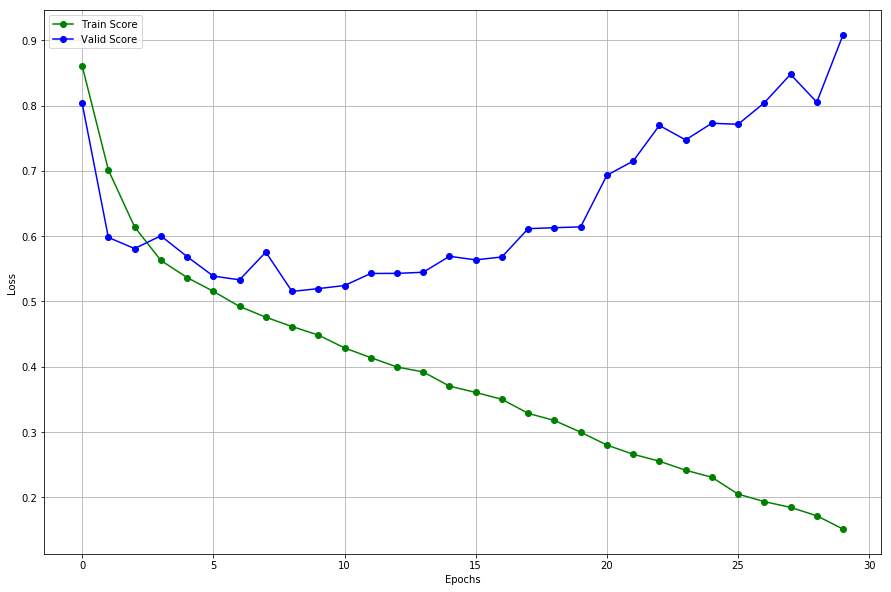

In [35]:
fig, ax = plt.subplots()

ax.plot(list(range(len(model_glove.train_history))), model_glove.train_history, 'g-o', label = 'Train Score')
ax.plot(list(range(len(model_glove.valid_history))), model_glove.valid_history, 'b-o', label = 'Valid Score', )
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid()

fig.set_figheight(10)
fig.set_figwidth(15)

In [36]:
# Loading the best model
print(model_glove.test(test_loader, batch_size, criterion))

checkpoint = torch.load('models/model_glove_200dims.pt')
model_glove.load_state_dict(checkpoint['model_state_dict'])

model_glove.test(test_loader, batch_size, criterion) 

Test loss: 0.898 Test accuracy: 0.759
None
Test loss: 0.487 Test accuracy: 0.824


In [37]:
# saving predictions
saving_preds('data/y_pred_glove_200', model_glove, flag = 'preds')
saving_preds('data/y_test_glove_200', model_glove, flag = 'labels')

In [39]:
import pickle

with open('data/vocab_to_int', 'wb') as fp:
    pickle.dump(vocab_to_int, fp)

In [40]:
for inputs, label in train_loader:
    print(inputs)
    break

tensor([[    0.,     0.,     0.,     0.,  8077.,  2788.,   504.,  9152.,  2252.,
          9560.,  2505.,   804.,  3751., 11393.,  9911.,  6320., 11063., 11522.,
          5344.,  4262.,  6290.,  4542.,  4262.,  6841., 10853.,  6320.,  8096.,
           804.,  7595.,  9748.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,   273.,  9036.,  9663.,  8084.,  6320.,  6053.,
          4084.,  4308.,  4262.,  2872.,  5070.,  1850.,  6493., 11409., 11370.,
          4886., 10784.,  6320.],
        [    0.,   273.,  7218.,  4308., 10669.,  9560.,  2471.,  8983.,  5877.,
          4308.,   896.,  2001.,  3050.,  1318.,   878.,  4886., 10784.,  4186.,
          8810.,  2741.,  9450.,  4262.,  6344.,  9663.,  5890.,  8416.,   286.,
          2872.,  1885.,  6320.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,  9689.,  8753., 11273.,  6844.,  4000.,
       